# Santander Product Recommendation - EDA

### Kaggle Link  - https://www.kaggle.com/competitions/santander-product-recommendation

### Overview -

Under their current system, a small number of Santander’s customers receive many recommendations while many others rarely see any resulting in an uneven customer experience. With a more effective recommendation system in place, Santander can better meet the individual needs of all customers and ensure their satisfaction no matter where they are in life.

In [73]:
#!pip install pycountry mlxtend -q

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import pycountry
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
from IPython.display import display
from mlxtend.frequent_patterns import apriori, association_rules

/kaggle/input/santander-recsys/sample_submission.csv
/kaggle/input/santander-recsys/first_acquisition_df.csv
/kaggle/input/santander-recsys/test_ver2.csv
/kaggle/input/santander-recsys/train_ver2.csv


## Key Takeaways from the EDA

1. `ind_cco_fin_ult1` (Current Account) is the most popular product followed by `ind_ctop_fin_ult1` (Particular Account) and `ind_recibo_ult1` (Direct Debt)
2. A large number of customers (~37000) had opted for `Particular Account` after `Current Account`
3. Number of customers constantly increased from 2012 to 2015
4. Product acquisition preferences were almost the same for both genders
5. Gross income (`renta`) is highly skewed, most people have income within 200,000

## Loading the training data and performing some basic checks

In [74]:
data = pd.read_csv("/kaggle/input/santander-recsys/train_ver2.csv")
print(f"Total number of transactions details : {data.shape[0]}")
print(f"Total number of features : {data.shape[1]}")

Total number of transactions details : 13647309
Total number of features : 48


### Column names and descritions as per the data page [here](https://www.kaggle.com/competitions/santander-product-recommendation/data)

| Column Name              | Description |
|--------------------------|-------------|
| fecha_dato               | The table is partitioned for this column |
| ncodpers                 | Customer code |
| ind_empleado             | Employee index: A active, B ex employed, F filial, N not employee, P pasive |
| pais_residencia          | Customer's Country residence |
| sexo                     | Customer's sex |
| age                      | Age |
| fecha_alta               | The date in which the customer became as the first holder of a contract in the bank |
| ind_nuevo                | New customer Index. 1 if the customer registered in the last 6 months. |
| antiguedad               | Customer seniority (in months) |
| indrel                   | 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month) |
| ult_fec_cli_1t           | Last date as primary customer (if he isn't at the end of the month) |
| indrel_1mes              | Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner) |
| tiprel_1mes              | Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential) |
| indresi                  | Residence index (S (Yes) or N (No) if the residence country is the same than the bank country) |
| indext                   | Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country) |
| conyuemp                 | Spouse index. 1 if the customer is spouse of an employee |
| canal_entrada            | Channel used by the customer to join |
| indfall                  | Deceased index. N/S |
| tipodom                  | Address type. 1, primary address |
| cod_prov                 | Province code (customer's address) |
| nomprov                  | Province name |
| ind_actividad_cliente    | Activity index (1, active customer; 0, inactive customer) |
| renta                    | Gross income of the household |
| segmento                 | Segmentation: 01 - VIP, 02 - Individuals 03 - college graduated |
| ind_ahor_fin_ult1        | Saving Account |
| ind_aval_fin_ult1        | Guarantees |
| ind_cco_fin_ult1         | Current Accounts |
| ind_cder_fin_ult1        | Derivada Account |
| ind_cno_fin_ult1         | Payroll Account |
| ind_ctju_fin_ult1        | Junior Account |
| ind_ctma_fin_ult1        | Más particular Account |
| ind_ctop_fin_ult1        | Particular Account |
| ind_ctpp_fin_ult1        | Particular Plus Account |
| ind_deco_fin_ult1        | Short-term deposits |
| ind_deme_fin_ult1        | Medium-term deposits |
| ind_dela_fin_ult1        | Long-term deposits |
| ind_ecue_fin_ult1        | e-account |
| ind_fond_fin_ult1        | Funds |
| ind_hip_fin_ult1         | Mortgage |
| ind_plan_fin_ult1        | Pensions |
| ind_pres_fin_ult1        | Loans |
| ind_reca_fin_ult1        | Taxes |
| ind_tjcr_fin_ult1        | Credit Card |
| ind_valo_fin_ult1        | Securities |
| ind_viv_fin_ult1         | Home Account |
| ind_nomina_ult1          | Payroll |
| ind_nom_pens_ult1        | Pensions |
| ind_recibo_ult1          | Direct Debit |


In [75]:
# Number of unique users
print(f"Total number of unique customer ids : {len(data['ncodpers'].unique())}")

Total number of unique customer ids : 956645


### Filtering to the Most Recent Transaction per Customer

1. Sort the data based on the `fecha_dato` (date) column.
2. Remove duplicates based on the `ncodpers` (customer code), keeping only the first (most recent) entry for each customer.
3. This will give us the most recent transaction for every customer.

In [76]:
# Convert to datetime data type and sort data by date
data['fecha_dato'] = pd.to_datetime(data['fecha_dato'])
user_latest_transaction = data.sort_values(['fecha_dato'], ascending=[False])
user_latest_transaction = user_latest_transaction.drop_duplicates(subset='ncodpers', keep='first')

In [77]:
# Sanity check. The number of records of user_latest_transaction will be same as number of unique customers
assert len(data['ncodpers'].unique()) == user_latest_transaction.shape[0]
print(f"Asserting successful")

Asserting successful


## Column - ind_empleado

**Description - Employee index. Possible values are** 
* A - active
* B - ex employed
* F - filial
* N - not employee
* P - pasive

In [78]:
user_latest_transaction['ind_empleado'].value_counts(normalize=True)

ind_empleado
N    0.999452
B    0.000231
F    0.000160
A    0.000156
S    0.000001
Name: proportion, dtype: float64

### Observations - 
1. Almost all the customers have the employee index N (the customer is not an employee of the bank)

## Column - pais_residencia

**Description - Country of residence of the customer**

In [79]:
pais_residencia_counts_normalized = user_latest_transaction['pais_residencia'].value_counts(normalize=True).reset_index()
pais_residencia_counts_normalized.columns = ['country_code', 'count']

### Fetching iso3 codes for each country. 

(This is just for plotting purpose since plotly uses iso_3 format)

In [80]:
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

pais_residencia_counts_normalized['iso_3'] = pais_residencia_counts_normalized['country_code'].apply(iso2_to_iso3)

In [81]:
# The iso_2 (column: country_code) has been converted to iso_3 (column: iso_alpha_3) format
pais_residencia_counts_normalized.head()

,country_code,count,iso_3
0,ES,0.995769,ESP
1,FR,0.000334,FRA
2,AR,0.000304,ARG
3,GB,0.000301,GBR
4,DE,0.000300,DEU


In [82]:
import plotly.express as px

fig = px.choropleth(
    pais_residencia_counts_normalized,
    locations='iso_3',
    locationmode='ISO-3',
    color='count',
    hover_name='country_code',
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Customer Distribution by Country'
)

fig.update_layout(coloraxis_colorbar_title='Proportion')
fig.show()

### Observation - 99.5% of the customers are from Spain (ESP). 0.03% customers are from France (FR) , Argentina (AR), Great Britain (GB) and Germany (DE) each. 

## Column - sexo

**Description - Sex of the Customer. Possible values are** 
* V - Female
* H - male

In [83]:
sexo_counts = user_latest_transaction['sexo'].value_counts(normalize=True)
sexo_counts.index = sexo_counts.index.map({'H': 'Male', 'V': 'Female'})

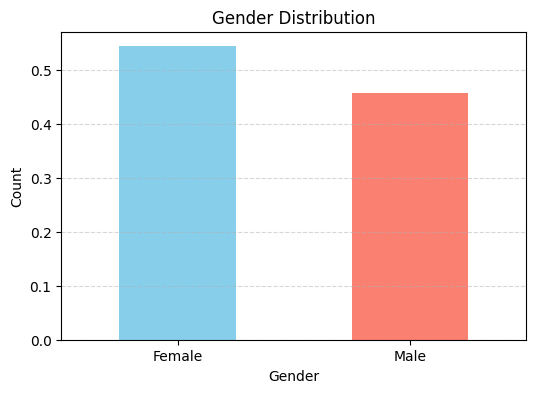

In [84]:
plt.figure(figsize=(6, 4))
sexo_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Observation - 55% customers are female

## Column - age

Description - Age of the customer

In [85]:
# We'll replace NA with np.nan

user_latest_transaction['age'].replace(' NA', np.nan, inplace=True)
print(f"Nan values in age : {user_latest_transaction['age'].isna().sum()}")

Nan values in age : 7031


### Analysing the age distribution

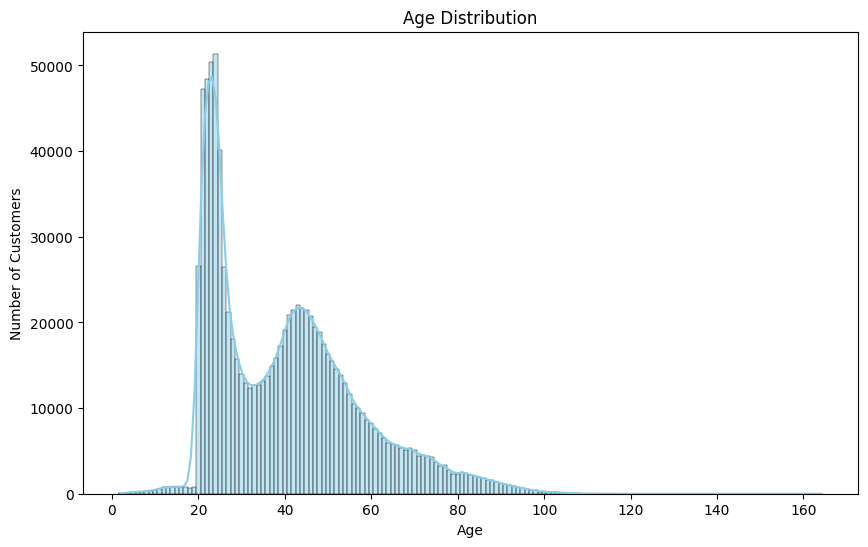

In [86]:
#Plotting age distribution

plt.figure(figsize=(10, 6))
sns.histplot(user_latest_transaction['age'].dropna(), bins=range(18, 90), kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

### There are a few customers beyond the age range of 18 to 100.

In [87]:
user_latest_transaction['age'] = pd.to_numeric(user_latest_transaction['age'], errors='coerce')
beyond_age_range = user_latest_transaction[(user_latest_transaction['age'] < 18) | (user_latest_transaction['age'] > 100)]

print(f"Customers outside the 18-100 threshold : {beyond_age_range.shape[0]}")
print(f"As percentage : {round((beyond_age_range.shape[0]/user_latest_transaction.shape[0])*100,4)}")

Customers outside the 18-100 threshold : 8482
As percentage : 0.8866


In [88]:
# Sex distribution for customers outside the age thresholds
print(f"Sex distribution of customers beyond the age threshold")
beyond_age_range['sexo'].value_counts(normalize=True)

Sex distribution of customers beyond the age threshold


sexo
H    0.505601
V    0.494399
Name: proportion, dtype: float64

### Observations - Sex ratio of customers beyond the age 18-100 is almost 1:1

### Analysing the age distribution for both genders

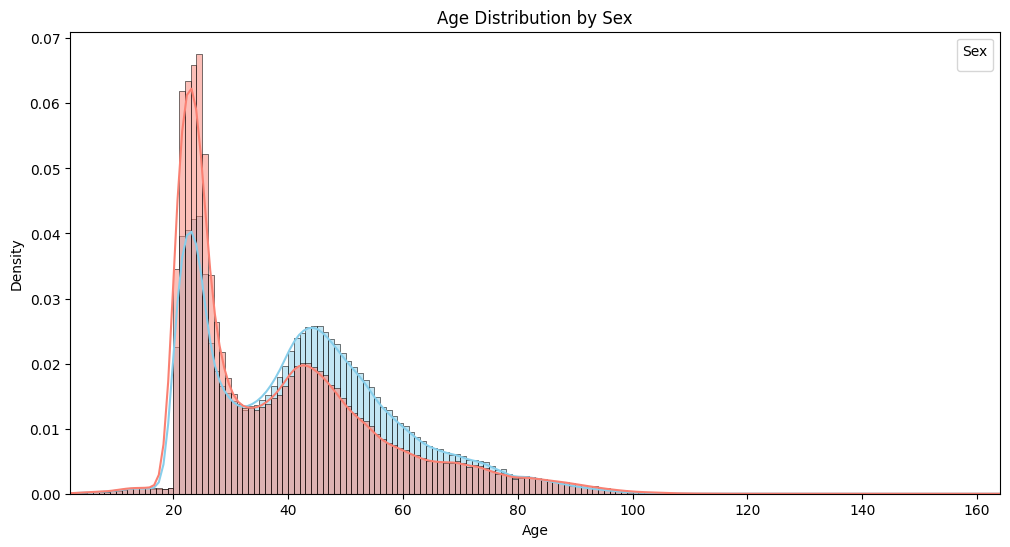

In [89]:
#Plotting age distribution by gender

plt.figure(figsize=(12, 6))
sns.histplot(
    data=user_latest_transaction,
    x='age',
    hue='sexo',
    bins=range(int(user_latest_transaction['age'].min()), int(user_latest_transaction['age'].max()) + 1),
    stat='density',
    common_norm=False,
    kde=True,
    palette={'V': 'skyblue', 'H': 'salmon'}
)
plt.title('Age Distribution by Sex')
plt.xlabel('Age')
plt.ylabel('Density')
plt.xlim(user_latest_transaction['age'].min(), user_latest_transaction['age'].max())
plt.legend(title='Sex')
plt.show()

### Age Bucketing for Analysis

We will divide the `age` column into the following buckets:

- **Bucket 1:** 0 to 18 years  
- **Bucket 2:** 18 to 30 years  
- **Bucket 3:** 30 to 45 years  
- **Bucket 4:** 45 to 60 years  
- **Bucket 5:** 60+ years


In [90]:
# Dividing the age into separate buckets
# Bin 1 - 0 to 18 , Bin 2 - 18 to 30, Bin 3 - 30 to 45, Bin 4 - 45 to 60, Bin 5 - 60+

age_bucket_labels = {
    '1': '0-18',
    '2': '18-30',
    '3': '30-45',
    '4': '45-60',
    '5': '60+'
}

bins = [0, 18, 30, 45, 60, np.inf]
labels = ['1', '2', '3', '4', '5']

# Convert the age to numeric and then map the age bucket to a label
user_latest_transaction['age'] = pd.to_numeric(user_latest_transaction['age'], errors='coerce')
user_latest_transaction['age_bucket'] = pd.cut(user_latest_transaction['age'], bins=bins, labels=labels, right=False)
user_latest_transaction['age_bucket_label'] = user_latest_transaction['age_bucket'].map(age_bucket_labels)

age_counts = user_latest_transaction['age_bucket_label'].value_counts().reset_index()

### Visualizing Age Bucket Distribution

Plotting the distribution of customers across the defined age buckets.

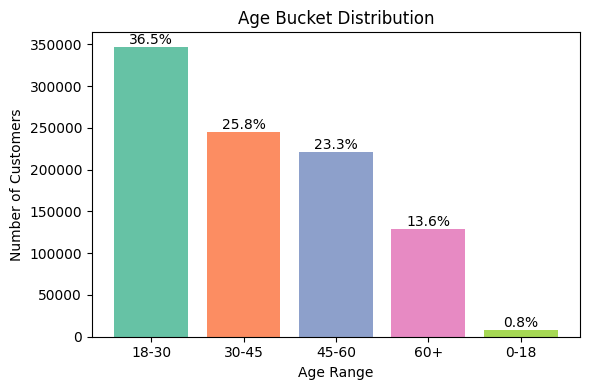

In [91]:
# Calculate normalized values (percentages)
total_count = age_counts['count'].sum()
age_counts['percentage'] = age_counts['count'] / total_count * 100

plt.figure(figsize=(6, 4))
bars = plt.bar(age_counts['age_bucket_label'], age_counts['count'], color=plt.get_cmap('Set2').colors)

# Add text annotations
for bar, pct in zip(bars, age_counts['percentage']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Age Bucket Distribution')
plt.xlabel('Age Range')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Observations - 
1. Maximum number of customers are from 18 - 30 age group (36.5%).
2. Almost 50% people are from 30 - 60 age group <br>
3. There are more number of females than males in 18-30 range. <br>
4. There are more number of males than females in 35-70 range. <br>

## Column - fecha_alta

**Description - The date in which the customer became as the first holder of a contract in the bank**

### Splitting Date into `MM-YYYY` and `YYYY` Formats

For analysis, we will split the feature into:

- **MM-YYYY**: Month and year (e.g.,`2016-05-13` will become `05-2016`)
- **YYYY**: Year only (e.g., `2016`)

In [92]:
# Converting the 'fecha_alta' column to datetime type
user_latest_transaction['fecha_alta'] = pd.to_datetime(user_latest_transaction['fecha_alta'])

# Splitting into MM-YYYY
user_latest_transaction['month_year'] = user_latest_transaction['fecha_alta'].dt.strftime('%m-%Y')

# Splitting into YYYY
user_latest_transaction['year'] = (user_latest_transaction['fecha_alta'].dt.year).astype('Int64')

### Selecting the Top 10 `month-year` combinations by Number of First Holders

We will identify the **top 10 month-year combinations** (`month_year`) that have the highest number of **first holders** for that month.

In [93]:
# Top 10 MM-YYYY combination
date_data = user_latest_transaction[['fecha_alta', 'month_year', 'year']]
top_10_mm_yyyy = date_data['month_year'].value_counts().nlargest(10)

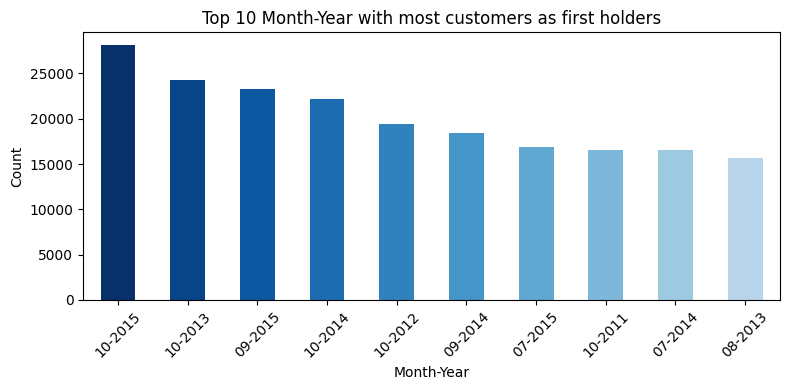

In [94]:
# Plot - Top 10 MM-YYYY combinations where customers became as 1st holder

colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_10_mm_yyyy)))

plt.figure(figsize=(8, 4))
top_10_mm_yyyy.plot(kind='bar', color=colors)
plt.title('Top 10 Month-Year with most customers as first holders')
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Selecting the Top 5 'year' combinations by Number of First Holders

We will identify the **top 5 years** (`year`) that have the highest number of **first holders** for that month.

In [95]:
top_5_yyyy = date_data['year'].value_counts().nlargest(5)

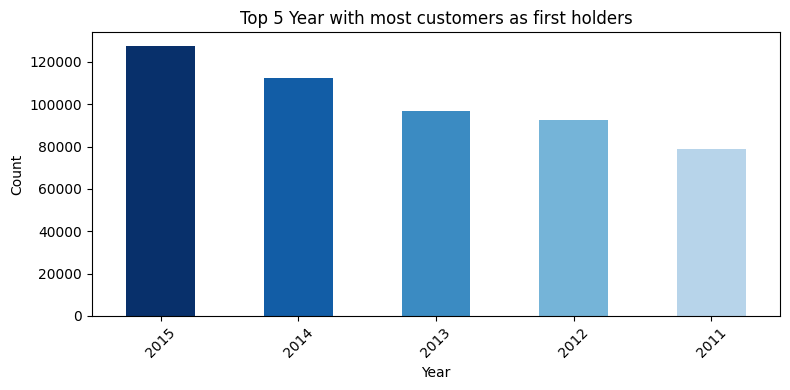

In [96]:
# Plot - Top 5 Years where customers became as 1st holder

colors = plt.cm.Blues(np.linspace(1, 0.3, len(top_5_yyyy)))

plt.figure(figsize=(8, 4))
top_5_yyyy.plot(kind='bar', color=colors)
plt.title('Top 5 Year with most customers as first holders')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations - 
1. Most of the new customers were in the latter half of the year.
2. No of customers becoming 1st holders have been increasing constantly from 2011 to 2015.

In [97]:
year_wise_trend = date_data['year'].value_counts().sort_index()

### Year wise trend of number of first holders from 1995 to mid 2016

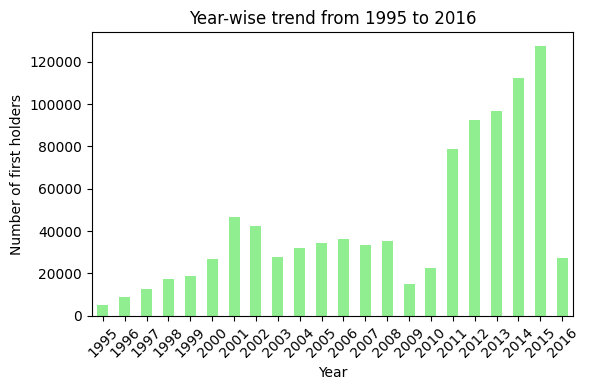

In [98]:
plt.figure(figsize=(6, 4))
year_wise_trend.plot(kind='bar', color='lightgreen')
plt.title('Year-wise trend from 1995 to 2016')
plt.xlabel('Year')
plt.ylabel('Number of first holders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Column - ind_nuevo

**Description - New customer Index. 1 if the customer registered in the last 6 months.**

In [99]:
print(f"New users in last 6 months : {user_latest_transaction['ind_nuevo'].value_counts().get(1)}")
new_cstmr_last_6_mths = user_latest_transaction[user_latest_transaction['ind_nuevo'] == 1]

New users in last 6 months : 43221


## Column - antiguedad

**Description - Customer seniority (in months)**

In [100]:
# Replacing '     NA' by np.nan
user_latest_transaction['antiguedad'] = user_latest_transaction['antiguedad'].replace('     NA', np.nan)

# Converting the column to numeric type
user_latest_transaction['antiguedad'] = pd.to_numeric(user_latest_transaction['antiguedad'], errors='coerce')

#There are certain entries with value = -999999.0. They are most probably invalid/placeholder data. We'll replace with nan for now
user_latest_transaction['antiguedad'] = user_latest_transaction['antiguedad'].replace(-999999.0, np.nan)

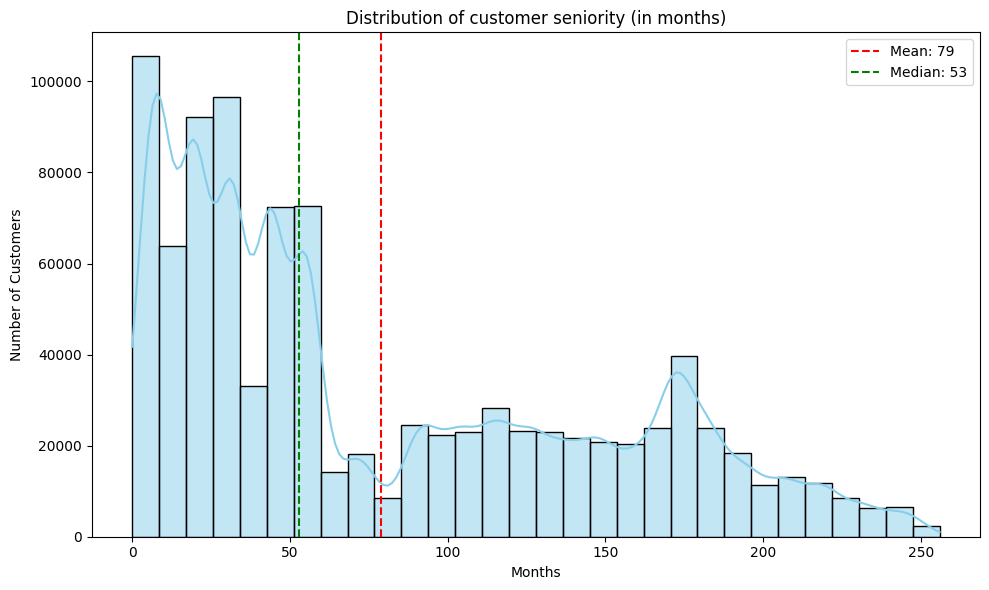

In [101]:
plt.figure(figsize=(10, 6))

mean = user_latest_transaction['antiguedad'].mean()
median = user_latest_transaction['antiguedad'].median()

sns.histplot(user_latest_transaction['antiguedad'], bins=30, kde=True, color='skyblue')
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.0f}')
plt.axvline(median, color='green', linestyle='--', label=f'Median: {median:.0f}')
plt.title('Distribution of customer seniority (in months)')
plt.xlabel('Months')
plt.ylabel('Number of Customers')
plt.legend()
plt.tight_layout()
plt.show()

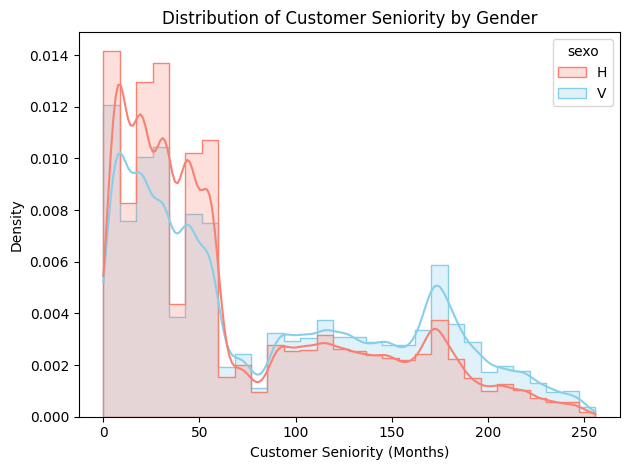

In [102]:
sns.histplot(
    data=user_latest_transaction,
    x='antiguedad',
    hue='sexo',
    bins=30,
    kde=True,
    palette={'V': 'skyblue', 'H': 'salmon'},
    element='step',
    stat='density',
    common_norm=False
)

plt.title('Distribution of Customer Seniority by Gender')
plt.xlabel('Customer Seniority (Months)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Observations - 
1. The seniority distribution is right skewed. A large number of customers have less seniority.
2. Number of customers gradually drops as the seniority increases.
3. Large number of customers are within 60 months old.
4. Within 50 months, male customers have slighlty higher density than female customers.
5. Longterm customers (> 100 months) - female customers have higher density. 

## Column - indrel_1mes

**Description - Customer type at the beginning of the month. Possible values are**
* 1 - First/Primary customer
* 2 - Co-owner
* 3 - Former primary
* 4 - Former co-owner
* P - Potential

In [103]:
# Each possible value is written in multiple formats, we'll normalize those first
user_latest_transaction['indrel_1mes'].unique()

array([nan, 1.0, 4.0, 3.0, 2.0, '1.0', '1', '2.0', 'P', '3.0', '2', '3',
       '4', '4.0'], dtype=object)

In [104]:
def normalize_value(x):
    try:
        if pd.isna(x):
            return np.nan
        num = float(x)
        return f'{num:.1f}'
    except:
        return str(x)

In [105]:
# applying normalize_value function on the 'indrel_1mes' column
user_latest_transaction['indrel_1mes'] = user_latest_transaction['indrel_1mes'].apply(normalize_value)

In [106]:
user_latest_transaction['indrel_1mes'].value_counts(normalize=True)

indrel_1mes
1.0    0.998921
3.0    0.000793
2.0    0.000139
P      0.000107
4.0    0.000039
Name: proportion, dtype: float64

### Observations - 
1. Almost all the customers are First/Primary customers

## Column - tiprel_1mes

**Description - Customer relation type at the beginning of the month. Possible values are**

* A - Active
* I - Inactive
* P - Former customer
* R - Potential

In [107]:
user_latest_transaction['tiprel_1mes'].value_counts(normalize=True)

tiprel_1mes
I    0.574301
A    0.424759
P    0.000832
R    0.000107
Name: proportion, dtype: float64

### Observations - 
1. At the starting of the month, 57% customers had inactive relation while 42% had active relation

### Analysing year wise count of Active and Inactive customers

1. We'll group based on the `year` and count the number if active and inactive customers for each year
2. For each year, we'll compute the difference between active and inactive customers

In [108]:
# Grouping the customers yearwise and finding the sum of different values of tiprel_1mes for each year
tiprel_1mes_year_wise = user_latest_transaction.groupby(['year', 'tiprel_1mes']).size().unstack(fill_value=0)

# Considering only Active and Inactive count
tiprel_1mes_year_wise = tiprel_1mes_year_wise[['A', 'I']]

# Finding the yearwise difference between Active and Inactive customers
tiprel_1mes_year_wise['A-I'] = tiprel_1mes_year_wise['A'] - tiprel_1mes_year_wise['I']

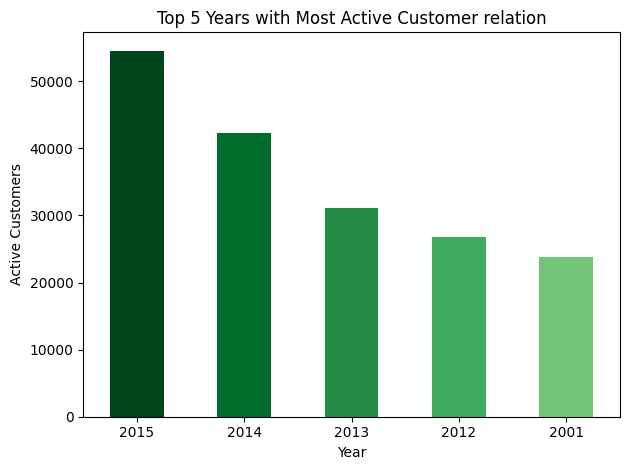

In [109]:
# 1. Top 5 years with most Active (A) relation
top5_A = tiprel_1mes_year_wise['A'].nlargest(5)

colors = plt.cm.Greens(np.linspace(1, 0.5, len(top5_A)))

top5_A.plot(kind='bar', title='Top 5 Years with Most Active Customer relation', color=colors)
plt.ylabel('Active Customers')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

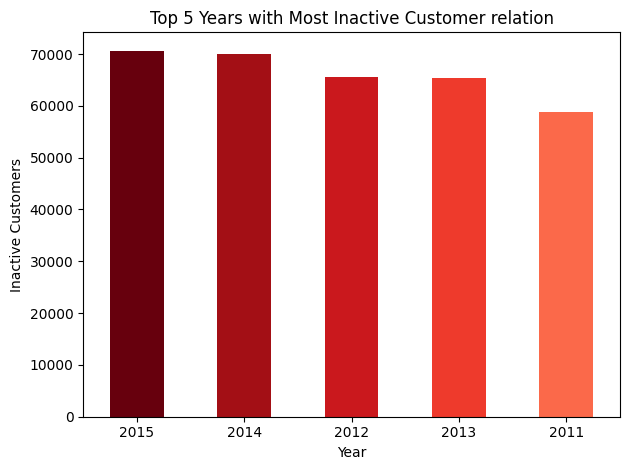

In [110]:
# 2. Top 5 years with most Inactive (I) relation
top5_I = tiprel_1mes_year_wise['I'].nlargest(5)
colors = plt.cm.Reds(np.linspace(1, 0.5, len(top5_I)))
top5_I.plot(kind='bar', title='Top 5 Years with Most Inactive Customer relation', color=colors)
plt.ylabel('Inactive Customers')
plt.xlabel('Year')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Observations - 
1. Active customers constantly increase from 2011 to 2015. There was a very gradual increase in inactive customers from 2011 to 2015

## Column - indresi	

**Description - Residence index. Possible values are**

* S - Yes, if the residence country is the same than the bank country
* N - No,  if the residence country is not the same than the bank country

In [111]:
user_latest_transaction['indresi'].value_counts(normalize=True)

indresi
S    0.995769
N    0.004231
Name: proportion, dtype: float64

### Finding the count of customers with `indresi` as S

Country wise count not needed here since there is only 1 possible value

In [112]:
# Just for the sake of verification - If residence index is S => Possible values for pais_residencia is Spain only.
# Since that is the bank country

residence_index_yes = user_latest_transaction[user_latest_transaction['indresi'] == 'S']
residence_index_yes['pais_residencia'].value_counts()

pais_residencia
ES    945596
Name: count, dtype: int64

### Finding the country wise count of customers with `indresi` as N

In [113]:
residence_index_no = user_latest_transaction[user_latest_transaction['indresi'] == 'N']
no_counts_by_country = residence_index_no.groupby('pais_residencia').size().sort_values(ascending=False)
top_10_no_counts_by_country = no_counts_by_country.head(10)

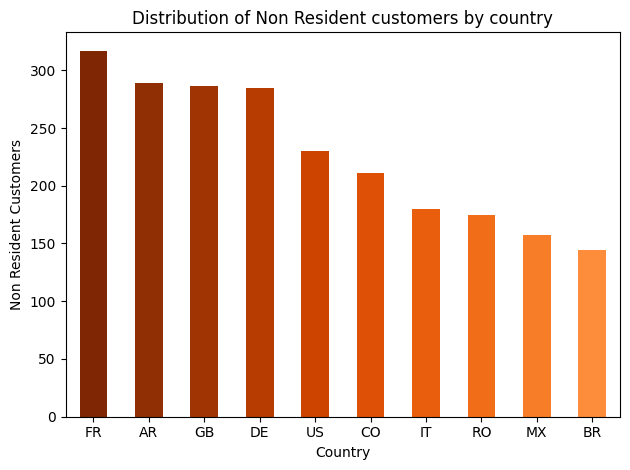

In [114]:
colors = plt.cm.Oranges(np.linspace(1, 0.5, len(top_10_no_counts_by_country)))

top_10_no_counts_by_country.plot(kind='bar', title='Distribution of Non Resident customers by country', color=colors)
plt.ylabel('Non Resident Customers')
plt.xlabel('Country')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Observation - 
1. 99.5% customers are from the same country as the bank country
2. For customers who are not from the same country as the bank country - France, Argentina, Great britain and Germany are top ones

## Column - indext

**Description - Foreigner index. Possible values are**

* S - Yes, if the customer's birth country is different than the bank country
* N - No,  if the customer's birth country is not different than the bank country

In [115]:
user_latest_transaction['indext'].value_counts(normalize=True)

indext
N    0.949885
S    0.050115
Name: proportion, dtype: float64

### Observations - 
1. ~95% customers are not Foreign Index customers

## Column - conyuemp

**Description - Spouse index. 1 if the customer is spouse of an employee**

In [116]:
user_latest_transaction['conyuemp'].isna().sum()/user_latest_transaction.shape[0]

0.9998735162991497

### Observations - 
1. Almost all are nan values!

## Column - canal_entrada

**Description - channel used by the customer to join**

In [117]:
user_latest_transaction['canal_entrada'].value_counts(normalize=True)

canal_entrada
KHE    0.270951
KAT    0.222095
KFC    0.216381
KHQ    0.081241
KHM    0.035404
         ...   
KGN    0.000001
KHR    0.000001
KDL    0.000001
KDB    0.000001
025    0.000001
Name: proportion, Length: 162, dtype: float64

### Almost 70% customers are from `KHE`, `KAT` and `KFC` channels

## Column - nomprov

**Description - Province name**

### Finding count of customers from each province

In [118]:
#Top 10 provinces
user_latest_transaction['nomprov'].value_counts().nlargest(10)

nomprov
MADRID       304576
BARCELONA     90484
VALENCIA      49028
SEVILLA       41366
CORUÑA, A     29271
MURCIA        28226
MALAGA        25096
ZARAGOZA      23563
ALICANTE      22761
CADIZ         20209
Name: count, dtype: int64

In [119]:
top5_provinces = user_latest_transaction['nomprov'].value_counts(normalize=True).nlargest(5) * 100

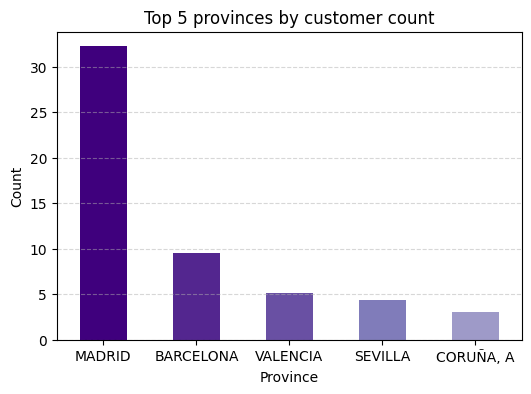

In [120]:
colors = plt.cm.Purples(np.linspace(1, 0.5, len(top5_provinces)))

plt.figure(figsize=(6, 4))
top5_provinces.plot(kind='bar', title='Top 5 provinces by customer count', color=colors)
plt.xlabel('Province')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### Observations - 
1. 32% customers are from Madrid.
2. Barcelona (9.5%), Valencia (5.1%), Sevilla (4.3%) and A Coruña (3.0%) account for approximately 20% of customers.

## Column - ind_actividad_cliente

**Decsription - Activity Index**

In [121]:
user_latest_transaction['ind_actividad_cliente'].value_counts(normalize=True)

ind_actividad_cliente
0.0    0.581962
1.0    0.418038
Name: proportion, dtype: float64

### Observations - 
1. 58% customers have inactive activity index

## Column - renta

**Description - Gross income of household**

In [122]:
user_latest_transaction['renta'].describe()

count    7.094110e+05
mean     1.340964e+05
std      2.322812e+05
min      1.202730e+03
25%      6.848994e+04
50%      1.014893e+05
75%      1.555271e+05
max      2.889440e+07
Name: renta, dtype: float64

CLIP THRESHOLD : 555605.55


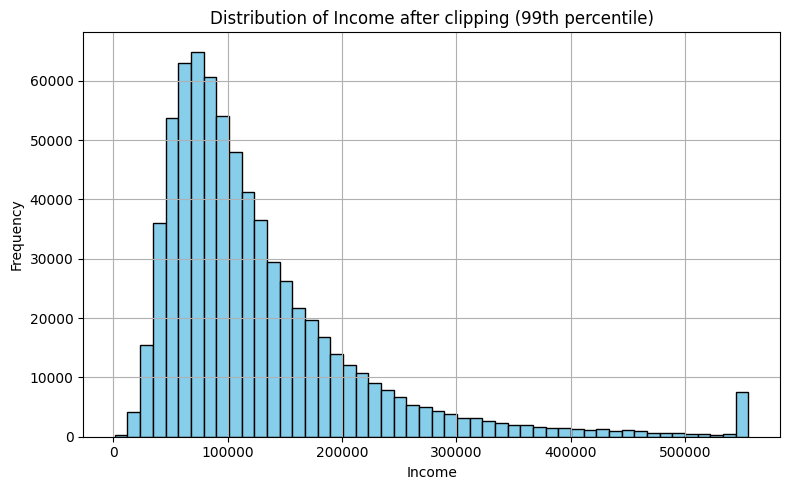

In [123]:
# Clip at 99th percentile
clip_threshold = user_latest_transaction['renta'].quantile(0.99)

print(f"CLIP THRESHOLD : {clip_threshold}")
plt.figure(figsize=(8, 5))
user_latest_transaction['renta'].clip(upper=clip_threshold).hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Income after clipping (99th percentile)')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

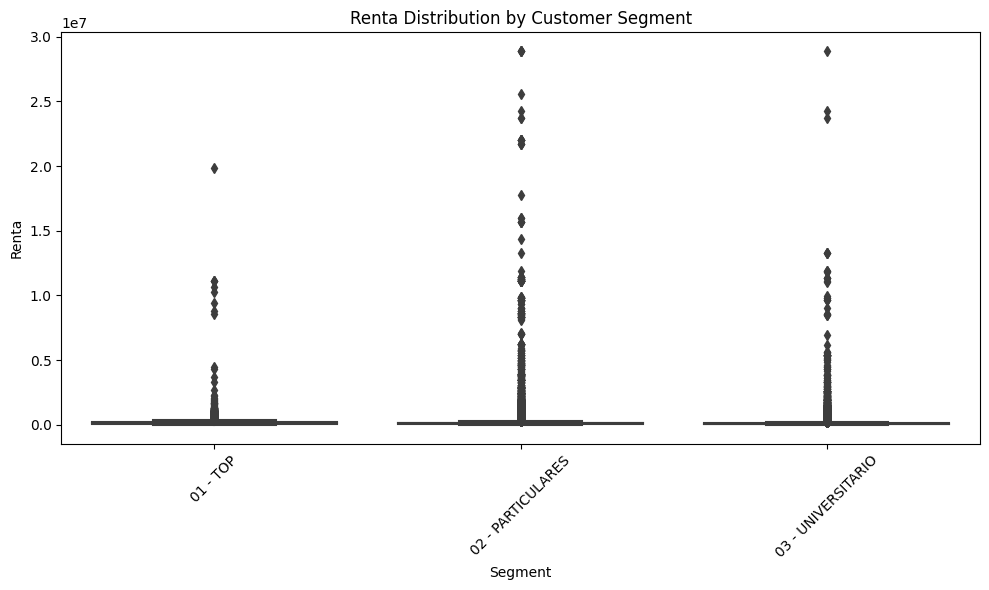

In [124]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_latest_transaction, x='segmento', y='renta')
plt.title('Renta Distribution by Customer Segment')
plt.ylabel('Renta')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mean `renta` by each value in `segmento`

In [125]:
data.groupby('segmento')['renta'].mean()

segmento
01 - TOP              175853.088546
02 - PARTICULARES     141558.185513
03 - UNIVERSITARIO    116431.558391
Name: renta, dtype: float64

### Observations:
1. The gross income `renta` is highly left skewed. Most number of people have income within 200,000
2. The peak frequency is around 80,000–100,000
3. `TOP` segment has the highest mean renta, followed by `PARTICULARES` and `UNIVERSITARIO`

### Storing the `product name` and `description` as key, value pairs

In [126]:
product_dict = {
    "ind_ahor_fin_ult1": "Saving Account",
    "ind_aval_fin_ult1": "Guarantees",
    "ind_cco_fin_ult1": "Current Accounts",
    "ind_cder_fin_ult1": "Derivada Account",
    "ind_cno_fin_ult1": "Payroll Account",
    "ind_ctju_fin_ult1": "Junior Account",
    "ind_ctma_fin_ult1": "Más particular Account",
    "ind_ctop_fin_ult1": "particular Account",
    "ind_ctpp_fin_ult1": "particular Plus Account",
    "ind_deco_fin_ult1": "Short-term deposits",
    "ind_deme_fin_ult1": "Medium-term deposits",
    "ind_dela_fin_ult1": "Long-term deposits",
    "ind_ecue_fin_ult1": "e-account",
    "ind_fond_fin_ult1": "Funds",
    "ind_hip_fin_ult1": "Mortgage",
    "ind_plan_fin_ult1": "Pensions",
    "ind_pres_fin_ult1": "Loans",
    "ind_reca_fin_ult1": "Taxes",
    "ind_tjcr_fin_ult1": "Credit Card",
    "ind_valo_fin_ult1": "Securities",
    "ind_viv_fin_ult1": "Home Account",
    "ind_nomina_ult1": "Payroll",
    "ind_nom_pens_ult1": "Pensions",
    "ind_recibo_ult1": "Direct Debit"
}

### Product Subscription Percentage (Based on Last Transaction Data)

For each product, we will calculate:

- **% Subscribed** – Percentage of customers who have subscribed to the product.
- **% Not Subscribed** – Percentage of customers who have not subscribed to the product.

In [127]:
p_data = []

for prod, desc in product_dict.items():
    value_count = user_latest_transaction[prod].value_counts(normalize=True)
    
    p_data.append({
    "Product" : prod,
    "Description" : desc,
    "0 value %" : value_count.get(0), # Not subscribed
    "1 value %" : value_count.get(1),# Subscribed
    })

In [128]:
prod_analysis = pd.DataFrame(p_data)

### The products are of format `ind_<xyz>_ult1`. Extracting all names in this format present in the dataframe columns.

In [129]:
product_cols = [col for col in data.columns if col.startswith('ind_') and col.endswith('ult1')]

print(f"Total products : {len(product_cols)}")

Total products : 24


### Monthly Product Usage Normalization

1. Group the data by `fecha_dato` and find the unique number of `ncodpers`. This gives the **number of unique customers** for each month (`monthly_total_customers`).

2. Calculate product usage per month:  `monthly_product_usage` stores the number of customers who have subscribed to each product for each month.

3. Normalize usage: For each month and product, we compute the ratio of customers subscribed to that product and total number of customers in that month. This gives the **percentage of customers** using that product in that month (`monthly_product_usage_normalized`).

In [130]:
# Calculating the percentage of customers who held a particular product in each month
monthly_total_customers = data.groupby('fecha_dato')['ncodpers'].nunique()
monthly_product_usage = data.groupby('fecha_dato')[product_cols].sum()
monthly_product_usage_normalized = (monthly_product_usage.div(monthly_total_customers, axis=0))* 100

In [131]:
# Since the data has been grouped based on `fecha_dato` the computation is done for each product, this record will have 17 rows (months) and 24 columns (product)

monthly_product_usage_normalized.shape

(17, 24)

### Visualizing `monthly_total_customers`

**Unique customers in each month**

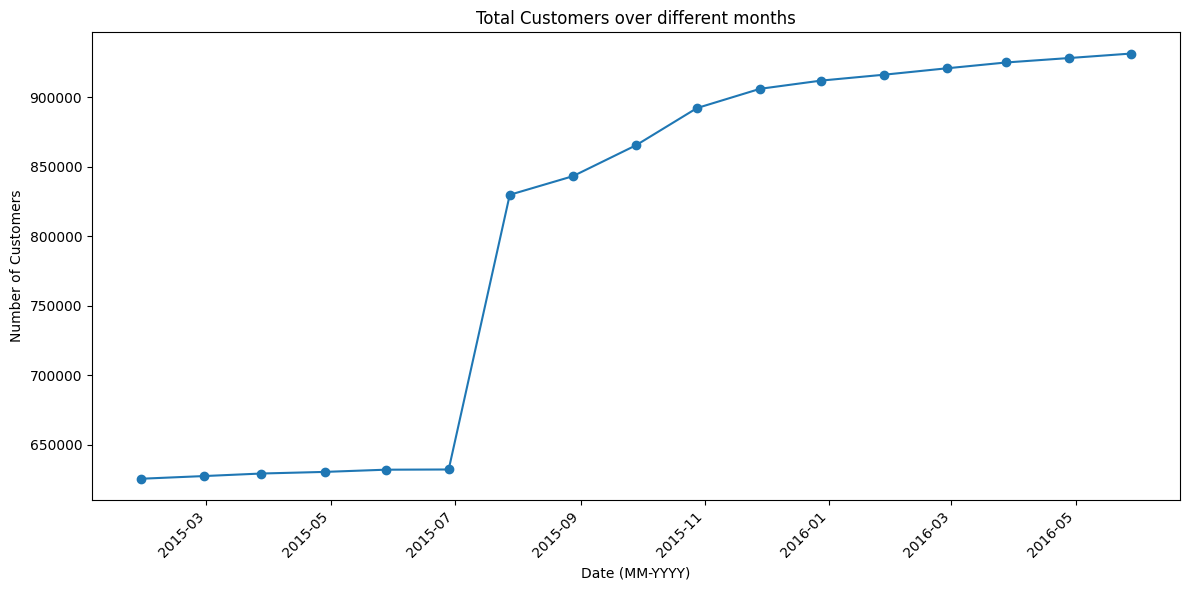

In [132]:
plt.figure(figsize=(12, 6))
monthly_total_customers.plot(marker='o', linestyle='-')
plt.title('Total Customers over different months')
plt.xlabel('Date (MM-YYYY)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualizing `monthly_product_usage_normalized`. 

**Each subplot shows the percentage of customers subscribed to a particular product across different dates.**


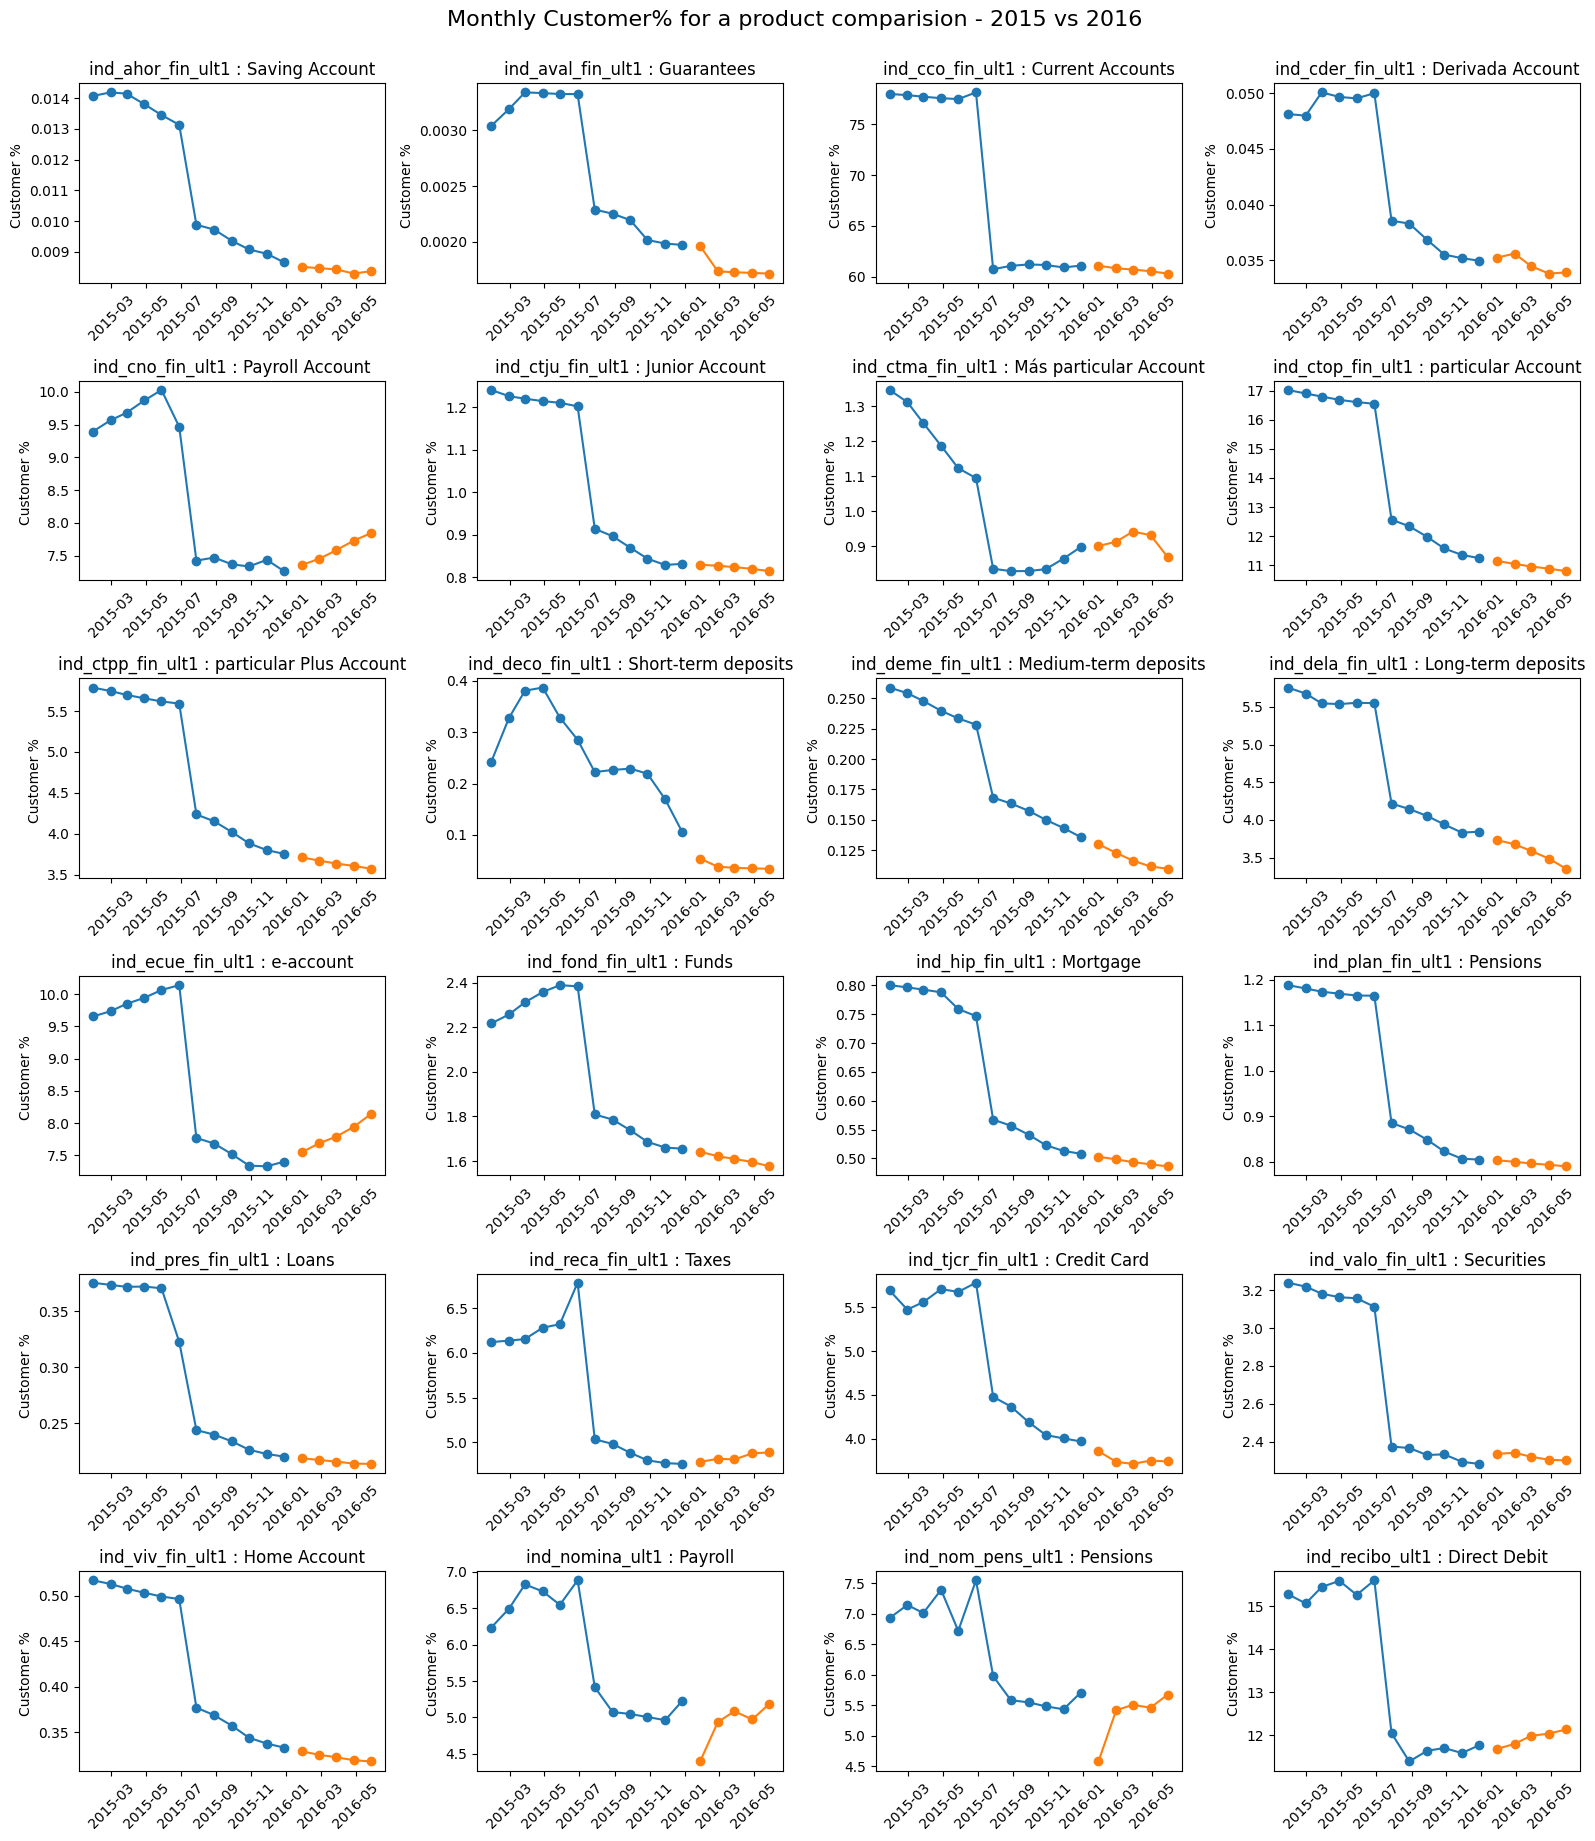

In [133]:
# Vizualing what percentage of subscribers (out of total for that month) had used a particular product - Comparing 2015 vs 2016

years = monthly_product_usage_normalized.index.year.unique()

n_products = len(product_dict)
ncols = 4  
nrows = int(n_products / 4)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 3), sharex=True)
axes = axes.flatten()

for idx, (product, desc) in enumerate(product_dict.items()):
    ax = axes[idx]
    for year in years:
        df = monthly_product_usage_normalized[monthly_product_usage_normalized.index.year == year]
        ax.plot(df.index, df[product], marker='o', linestyle='-')
    
    ax.set_title(f"{product} : {desc}")
    ax.set_ylabel('Customer % ')
    ax.tick_params(axis='x', which='both', labelbottom=True, rotation=45)
    
    # If there are any unused subplots, hide them
for empty in axes[n_products:]:
    empty.set_visible(False)

plt.tight_layout()
plt.suptitle(f'Monthly Customer% for a product comparision - 2015 vs 2016', y=1.02, fontsize=16)
plt.show()

### Mean Monthly Usage per Product

From the `monthly_product_usage_normalized`, we will compute the **mean value** for each product.

- The **mean value** for a product is calculated as the average of its normalized usage percentages across **all months**.

In [134]:
# Find the mean and select the top 5
n = 5
top_n_products = monthly_product_usage_normalized.mean().sort_values(ascending=False).head(n)

# Format and print
print(f"Top {n} products :")
for idx, name in enumerate(list(top_n_products.index)):
    print(f"{name} ({product_dict[name]}) : {top_n_products.values[idx]}")

Top 5 products :
ind_cco_fin_ult1 (Current Accounts) : 66.8431412121023
ind_ctop_fin_ult1 (particular Account) : 13.32167004000514
ind_recibo_ult1 (Direct Debit) : 13.062198876005553
ind_ecue_fin_ult1 (e-account) : 8.444099195406746
ind_cno_fin_ult1 (Payroll Account) : 8.251728365471243


In [135]:
top_n_products_list = list(top_n_products.index)

### Finding Frequently Occurring Product Combinations

1. Create `transaction_id` of the format `<ncodpers>_<fecha_dato>`  
   
2. Filter for top products: Use only the **top `n` products** identified in the earlier analysis.

3. Group by `transaction_id`: Each group will contain all rows belonging to that particular `transaction_id`.

4. Find subscribed products: For each group, identify products that have been **subscribed to at least once**.


In [136]:
# Creating a new column transaction_id with format <ncodpers>_<fecha_dato>
data['transaction_id'] = data['ncodpers'].astype(str) + '_' + data['fecha_dato'].astype(str)

# Extracting only transaction_id and top_n_product columns from the data
transaction_data = data[['transaction_id'] + top_n_products_list]

# For all product columns, replacing nan values with 0 and converting to int
for col in product_cols:
    data[col] = data[col].fillna(0).astype('int8')

# Grouping by transaction_id and if a product has been subscribed atleast once (for that transaction) , setting value as 1 for that product column
transaction_data = data.groupby('transaction_id')[top_n_products_list].any().astype(int)

### Finding Frequent Product Combinations with Apriori and Association Rules

1. We will use the **Apriori algorithm** to identify frequently occurring combinations of products.  
2. After generating the **frequent item sets** (`frequent_items`), we will apply **Association Rule Mining** to discover relationships between products (combinations of products that are subscribed together)

NOTE: This computation is memory intensive, to reduce computation time the sum of `antecendents` and `consequents` (`total_ant_con`) has been limited to 3 for a given rule.

For more details, see the [Apriori algorithm](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) and [Association Rules](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) documentation.



In [137]:
def run_apriori_batch(df,batch_size=2000000,min_support=0.001):
    n_rows = df.shape[0]
    all_rules = []
    total_ant_con = 3

    for i in range(0, n_rows, batch_size):
        end = min(i + batch_size, n_rows)
        print(f"Processing rows {i} to {end}...")
        batch = df.iloc[i:end].copy()
        
        try:
            # frequent items will be a dataframe with combinations of product along with score
            frequent_items = apriori(batch, min_support=min_support, use_colnames=True)
            if frequent_items.empty:
                print("No frequent itemsets in this batch.")
                continue
            
            rules = association_rules(frequent_items, metric='confidence', min_threshold=min_support)
            rules = rules[(rules['antecedents'].apply(len) + rules['consequents'].apply(len) == total_ant_con)]
            all_rules.append(rules)

        except Exception as e:
            print(f"Error in batch {i}-{end}: {e}")
            continue

    combined_rules = pd.concat(all_rules, ignore_index=True)
    combined_rules.drop_duplicates(subset=["antecedents", "consequents"], inplace=True)
    combined_rules.sort_values(by="confidence", ascending=False, inplace=True)

    return combined_rules

In [138]:
batch_len = 2000000
min_support = 0.001

rules_data = run_apriori_batch(
    df=transaction_data,
    batch_size=batch_len,
    min_support=min_support
)

Processing rows 0 to 2000000...
Processing rows 2000000 to 4000000...
Processing rows 4000000 to 6000000...
Processing rows 6000000 to 8000000...
Processing rows 8000000 to 10000000...
Processing rows 10000000 to 12000000...
Processing rows 12000000 to 13647309...


In [139]:
print(f"Total rules generated: {rules_data.shape[0]}")

Total rules generated: 60


### `association_rules` generates a set of rules (`rules_data`) from the frequent items. It contains `antecedents`, `consequents` and some other metrics.

- Association rules are expressed in the form of "if X, then Y" where X is the `antecedent` and Y is the `consequent`. 
- The `confidence` of a rule "if X, then Y" is the probability of seeing the consequent (Y) in a transaction given that it also contains the antecedent (X)

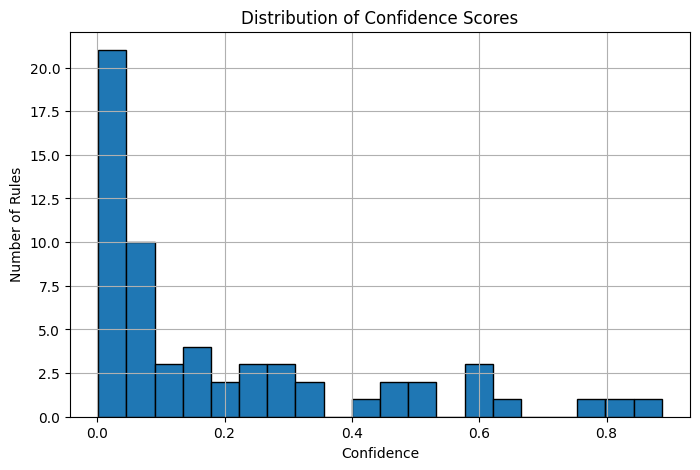

In [140]:
plt.figure(figsize=(8, 5))
rules_data['confidence'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence')
plt.ylabel('Number of Rules')
plt.grid(True)
plt.show()

### Analysing top rules

- We will replace the antecedents and consequents with their corresponding english names/description (`rules_data_simplified`) and select only those rules which have confidence greater than 0.5

In [141]:
# For each item in antecedent/consequent fetch the corresponding description from the product_dict

def map_product_names(itemset):
    return tuple(product_dict.get(item, item) for item in itemset)

def apply_product_name_mapping(df):
    df['antecedents'] = df['antecedents'].apply(map_product_names)
    df['consequents'] = df['consequents'].apply(map_product_names)
    return df

In [142]:
rules_data_simplified = rules_data.copy()
rules_data_simplified = apply_product_name_mapping(rules_data_simplified)

# Selecting rules with confidence greater than 0.5
confidence_greater_than_05 = rules_data_simplified[rules_data_simplified['confidence'] > 0.50]

print(f"Total rules with confidence greater than 0.5 : {confidence_greater_than_05.shape[0]}")

Total rules with confidence greater than 0.5 : 8


In [143]:
print(f"Top rules for Female :")
display(confidence_greater_than_05[['antecedents','consequents','confidence']])

Top rules for Female :


,antecedents,consequents,confidence
18,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.886858
36,"(particular Account, Payroll Account)","(Direct Debit,)",0.818458
42,"(e-account, Payroll Account)","(Direct Debit,)",0.798030
30,"(particular Account, e-account)","(Direct Debit,)",0.630967
43,"(e-account, Direct Debit)","(Payroll Account,)",0.604874
6,"(particular Account, e-account)","(Current Accounts,)",0.598131
1,"(particular Account, Direct Debit)","(Current Accounts,)",0.580780
37,"(particular Account, Direct Debit)","(Payroll Account,)",0.513035


### Observations - 
1. If Customer has `Current Account` and `Payroll Account` - ~89% also have Direct Debit account
2. If Customer has `Particular Account` and `Payroll Account` - ~82% also have Direct Debit account

Generally speaking, if a customer owns all the products listed in the **_antecedents_**, then approximately **_confidence%_** of such customers also own the product(s) listed in the **_consequents_**.

### Analyzing the monthly usage percentage for top 11 products.

We'll compute the mean of monthly product usage (`monthly_product_usage_normalized`) across all months and select the **top 11 products** (`top11_monthly`)

In [144]:
monthly_product_usage_normalized.mean().nlargest(11)

ind_cco_fin_ult1     66.843141
ind_ctop_fin_ult1    13.321670
ind_recibo_ult1      13.062199
ind_ecue_fin_ult1     8.444099
ind_cno_fin_ult1      8.251728
ind_nom_pens_ult1     6.064153
ind_nomina_ult1       5.589876
ind_reca_fin_ult1     5.365333
ind_tjcr_fin_ult1     4.572500
ind_ctpp_fin_ult1     4.478290
ind_dela_fin_ult1     4.440438
dtype: float64

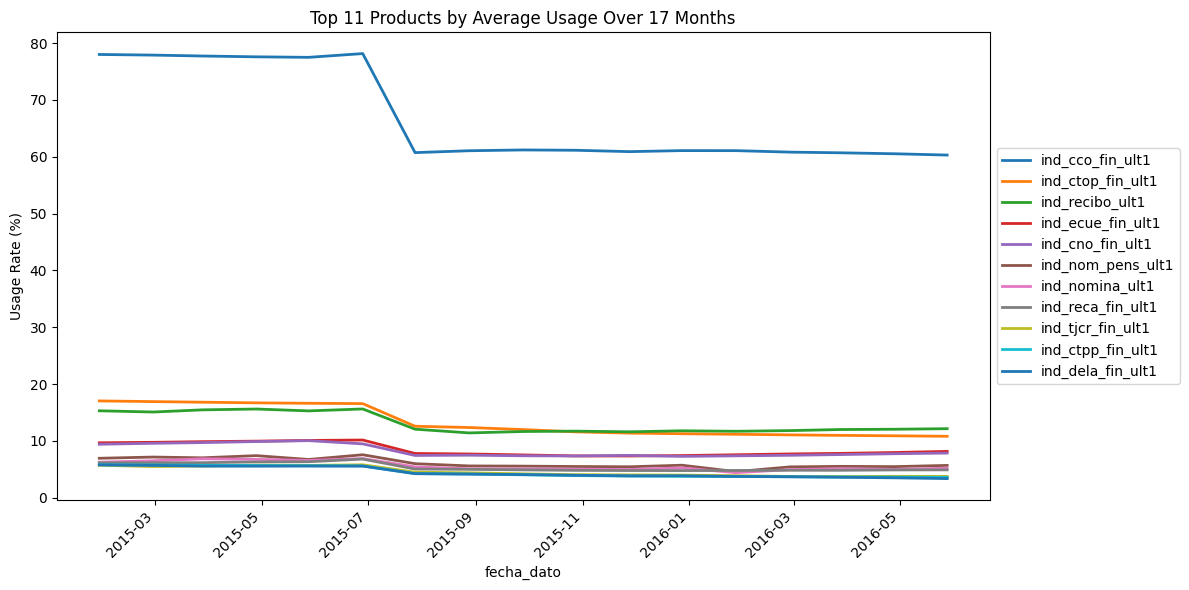

In [145]:
top11_monthly = monthly_product_usage_normalized.mean().nlargest(11).index.tolist()
ax = monthly_product_usage_normalized[top11_monthly].plot(figsize=(12, 6), linewidth=2)
ax.set_ylabel("Usage Rate (%)")
ax.set_title("Top 11 Products by Average Usage Over 17 Months")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations: 
1. `ind_cco_fin_ult1 (Current Accounts)` has the highest usage rate constantly across all products.
2. There is a sharp dip in the number of usage rate around mid-2015 across all products.
3. `ind_ctop_fin_ult1 (particular Account)` and `ind_recibo_ult1 (Direct Debit)` have very similar usage rate which is followed by `ind_ecue_fin_ult1 (e-account)` and `ind_cno_fin_ult1 (Payroll Account)`.
4. `ind_nom_pens_ult1 (Pensions)`, `ind_nomina_ult1 (Payroll)`, `ind_reca_fin_ult1 (Taxes)`, `ind_tjcr_fin_ult1 (Credit Card)`, `ind_ctpp_fin_ult1 (particular Plus Account)` and `ind_dela_fin_ult1 (Long-term deposits)` have usage rage between 4.5 to 6 %


## Common product combinations based on gender

We'll use `apriori` and `association rules` to find common combinations of products for each gender.

In [146]:
transaction_data = data.groupby('transaction_id')[top_n_products_list].any().astype(int)

### Grouping Data by Transaction ID and Separating by Gender

1. Group the data based on `transaction_id`
2. Separate the grouped data by the `sexo` column to analyze product patterns for **male** and **female** customers independently.


In [147]:
transaction_gender = data.groupby('transaction_id')['sexo'].first()

transaction_data = transaction_data.copy()
transaction_data['sexo'] = transaction_gender

transaction_data_male = transaction_data[transaction_data['sexo'] == 'H']
transaction_data_female = transaction_data[transaction_data['sexo'] == 'V']

transaction_data_male = transaction_data_male.drop(['sexo'], axis=1)
transaction_data_female = transaction_data_female.drop(['sexo'], axis=1)

### Rule generation for males

In [148]:
batch_len = 2000000
min_support = 0.001

rules_data_male = run_apriori_batch(
    df=transaction_data_male,
    batch_size=batch_len,
    min_support=min_support
)

Processing rows 0 to 2000000...
Processing rows 2000000 to 4000000...
Processing rows 4000000 to 6000000...
Processing rows 6000000 to 6195253...


### Rule generation for females

In [149]:
rules_data_female = run_apriori_batch(
    df=transaction_data_female,
    batch_size=batch_len,
    min_support=min_support
)

Processing rows 0 to 2000000...
Processing rows 2000000 to 4000000...
Processing rows 4000000 to 6000000...
Processing rows 6000000 to 7424252...


### Analysing top rules for each gender

Like earlier, we will replace the `antecedents` and `consequents` with their corresponding english names/description (rules_data_simplified) and select only those rules which have `confidence` greater than `confidence_threshold` = 0.5 

In [150]:
confidence_threshold = 0.5

# Storing a copy of rules
rules_data_male_simplified = rules_data_male.copy()
rules_data_female_simplified = rules_data_female.copy()

# Replacing antecedents and consequents with english names
rules_data_male_simplified = apply_product_name_mapping(rules_data_male_simplified)
rules_data_female_simplified = apply_product_name_mapping(rules_data_female_simplified)

# Filtering based on confidence value
confidence_greater_than_05_female = rules_data_female_simplified[rules_data_female_simplified['confidence'] > confidence_threshold]
confidence_greater_than_05_male = rules_data_male_simplified[rules_data_male_simplified['confidence'] > confidence_threshold]

In [151]:
print(f"Rules for Female :")
display(confidence_greater_than_05_female[['antecedents','consequents','confidence']])


print(f" \nRules for Male :")
display(confidence_greater_than_05_male[['antecedents','consequents','confidence']])

Rules for Female :


,antecedents,consequents,confidence
18,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.887779
36,"(particular Account, Payroll Account)","(Direct Debit,)",0.843239
48,"(e-account, Payroll Account)","(Direct Debit,)",0.801417
6,"(particular Account, e-account)","(Current Accounts,)",0.625215
30,"(particular Account, e-account)","(Direct Debit,)",0.617180
49,"(e-account, Direct Debit)","(Payroll Account,)",0.600755
1,"(particular Account, Direct Debit)","(Current Accounts,)",0.596882


 
Rules for Male :


,antecedents,consequents,confidence
12,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.881794
30,"(particular Account, Payroll Account)","(Direct Debit,)",0.844816
36,"(e-account, Payroll Account)","(Direct Debit,)",0.790655
24,"(particular Account, e-account)","(Direct Debit,)",0.669887
48,"(particular Account, e-account)","(Current Accounts,)",0.651764
37,"(e-account, Direct Debit)","(Payroll Account,)",0.627942
31,"(particular Account, Direct Debit)","(Payroll Account,)",0.547123
1,"(particular Account, Direct Debit)","(Current Accounts,)",0.544064


In [152]:
confidence_greater_than_05_male[['antecedents', 'consequents', 'confidence']]

,antecedents,consequents,confidence
12,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.881794
30,"(particular Account, Payroll Account)","(Direct Debit,)",0.844816
36,"(e-account, Payroll Account)","(Direct Debit,)",0.790655
24,"(particular Account, e-account)","(Direct Debit,)",0.669887
48,"(particular Account, e-account)","(Current Accounts,)",0.651764
37,"(e-account, Direct Debit)","(Payroll Account,)",0.627942
31,"(particular Account, Direct Debit)","(Payroll Account,)",0.547123
1,"(particular Account, Direct Debit)","(Current Accounts,)",0.544064


## Common product combinations based on segment

We'll use `apriori` and `association rules` to find common combinations of products for each segment (`segmento`)

In [153]:
transaction_data = data.groupby('transaction_id')[top_n_products_list].any().astype(int)

### Grouping Data by Transaction ID and Separating by Segment

1. Group the data based on `transaction_id`
2. Separate the grouped data by the `segmento` column to analyze product patterns for each customer segment independently.


In [154]:
transaction_segment = data.groupby('transaction_id')['segmento'].first()

transaction_data = transaction_data.copy()
transaction_data['segment'] = transaction_segment

transaction_data_seg01 = transaction_data[transaction_data['segment'] == '01 - TOP']
transaction_data_seg01 = transaction_data_seg01.drop(['segment'], axis=1)

transaction_data_seg02 = transaction_data[transaction_data['segment'] == '02 - PARTICULARES']
transaction_data_seg02 = transaction_data_seg02.drop(['segment'], axis=1)

transaction_data_seg03 = transaction_data[transaction_data['segment'] == '03 - UNIVERSITARIO']
transaction_data_seg03 = transaction_data_seg03.drop(['segment'], axis=1)

### Rules generation for Segment 01 (TOP)

In [155]:
rules_data_seg01 = run_apriori_batch(
    df=transaction_data_seg01,
    batch_size=batch_len,
    min_support=min_support
)

Processing rows 0 to 562142...


### Rules generation for Segment 02 (PARTICULARES)

In [156]:
rules_data_seg02 = run_apriori_batch(
    df=transaction_data_seg02,
    batch_size=batch_len,
    min_support=min_support
)

Processing rows 0 to 2000000...
Processing rows 2000000 to 4000000...
Processing rows 4000000 to 6000000...
Processing rows 6000000 to 7960220...


### Rules generation for Segment 03 (UNIVERSITARIO)

In [157]:
rules_data_seg03 = run_apriori_batch(
    df=transaction_data_seg03,
    batch_size=batch_len,
    min_support=min_support
)

Processing rows 0 to 2000000...
Processing rows 2000000 to 4000000...
Processing rows 4000000 to 4935579...


### Once rules have been generated for all segments, we replace the antecedent and consequent with english names and select only those records which have a confidence value more than 0.5

In [158]:
# Simplify names
rules_data_seg01 = apply_product_name_mapping(rules_data_seg01)
rules_data_seg02 = apply_product_name_mapping(rules_data_seg02)
rules_data_seg03 = apply_product_name_mapping(rules_data_seg03)

# Filter values greater than 0.5
confidence_greater_than_05_seg_01 = rules_data_seg01[rules_data_seg01['confidence'] > 0.50]
confidence_greater_than_05_seg_02 = rules_data_seg02[rules_data_seg02['confidence'] > 0.50]
confidence_greater_than_05_seg_03 = rules_data_seg03[rules_data_seg03['confidence'] > 0.50]

In [159]:
print(f"Rules for Segment 1 (TOP) :")
display(confidence_greater_than_05_seg_01[['antecedents','consequents','confidence']])

print(f" \nRules for Segment 2 (PARTICULARES) :")
display(confidence_greater_than_05_seg_02[['antecedents','consequents','confidence']])

print(f" \nRules for Segment 3 (UNIVERSITARIO) :")
display(confidence_greater_than_05_seg_03[['antecedents','consequents','confidence']])


Rules for Segment 1 (TOP) :


,antecedents,consequents,confidence
24,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.926852
54,"(e-account, Payroll Account)","(Direct Debit,)",0.842341
42,"(particular Account, Payroll Account)","(Direct Debit,)",0.811138
55,"(e-account, Direct Debit)","(Payroll Account,)",0.711633
56,"(Payroll Account, Direct Debit)","(e-account,)",0.707940
31,"(Current Accounts, Payroll Account)","(e-account,)",0.700285
6,"(particular Account, e-account)","(Current Accounts,)",0.634428
20,"(Current Accounts, Direct Debit)","(e-account,)",0.602325
43,"(particular Account, Direct Debit)","(Payroll Account,)",0.582266
58,"(Payroll Account,)","(e-account, Direct Debit)",0.580439


 
Rules for Segment 2 (PARTICULARES) :


,antecedents,consequents,confidence
24,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.909597
42,"(particular Account, Payroll Account)","(Direct Debit,)",0.844132
54,"(e-account, Payroll Account)","(Direct Debit,)",0.796218
6,"(particular Account, e-account)","(Current Accounts,)",0.624633
36,"(particular Account, e-account)","(Direct Debit,)",0.607548
1,"(particular Account, Direct Debit)","(Current Accounts,)",0.597460
55,"(e-account, Direct Debit)","(Payroll Account,)",0.580135


 
Rules for Segment 3 (UNIVERSITARIO) :


,antecedents,consequents,confidence
6,"(Current Accounts, Payroll Account)","(Direct Debit,)",0.758858
12,"(e-account, Payroll Account)","(Direct Debit,)",0.730698
42,"(particular Account, Payroll Account)","(Direct Debit,)",0.719001
13,"(e-account, Direct Debit)","(Payroll Account,)",0.628397
36,"(particular Account, e-account)","(Direct Debit,)",0.590238
43,"(particular Account, Direct Debit)","(Payroll Account,)",0.542624
48,"(particular Account, e-account)","(Payroll Account,)",0.518148
19,"(particular Account, Direct Debit)","(Current Accounts,)",0.506269


## Product Acquisition Lifecycle

Analyzing what are the common sequences in which products are purchased. This analysis will be done on the top 11 products (`top11_monthly`)

`customer_product_timeline` contains `fecha_dato`, `ncodpers` and transaction data of `top11_monthly` products. The data is sorted by `fecha_dato`

In [160]:
# Sort by customer and date
data_sorted = data.sort_values(['ncodpers', 'fecha_dato'])
customer_product_timeline = data_sorted[['ncodpers', 'fecha_dato'] + top11_monthly]

### Finding the First Acquisition Date for Each Product

For each product `p` in the `top11_monthly` list:

1. Group the data by `ncodpers` (customer ID), `fecha_dato` and the product column `p`

2. Filter the data to include only records where the product value = `1`, indicating the product was subscribed

3. Select the first record for each group. Since the data is already sorted by date, this first record represents  the **earliest date** when that product was subscribed to by that customer.

4. Repeat this computation for all products in the list.

The result will be stored in a dictionary named `first_acquisition`, with product name `p` as the key and date as the value

**NOTE - The computation takes some time so I've pre computed and stored the data as csv.**

In [161]:
# # first_acquisition = {}

# for product in top11_monthly:
#     print(f"Getting for {product}")
#     acquired = customer_product_timeline.groupby('ncodpers')[['fecha_dato', product]].apply(
#         lambda df: df[df[product] == 1].head(1)
#     )
#     acquired = acquired.reset_index(level=0, drop=True)
#     print(f"Reset Index")
#     acquired['product'] = product
#     acquired = acquired.rename(columns={'fecha_dato': 'first_acquired'})
#     print(f"Rename columns")
#     first_acquisition[product] = acquired[['first_acquired', 'product']]
#     print(f"Data for {product} added to dict \n")

# # Combine all into one dataframe
# first_acquisition_df = pd.concat(first_acquisition.values())

### Loading the pre computed data

In [162]:
first_acquisition_df = pd.read_csv("/kaggle/input/santander-recsys/first_acquisition_df.csv")

In [163]:
first_acquisition_df.head()

,ncodpers,first_acquired,product
0,416965,2015-01-28,ind_cco_fin_ult1
1,4078994,2015-07-28,ind_cco_fin_ult1
2,3565738,2015-06-28,ind_cco_fin_ult1
3,416969,2015-01-28,ind_cco_fin_ult1
4,416970,2015-01-28,ind_cco_fin_ult1


### Top 5 products which were subscribed first

In [164]:
first_acquisition_df['product'].value_counts(normalize=True).head(5)

product
ind_cco_fin_ult1     0.447284
ind_recibo_ult1      0.112967
ind_ctop_fin_ult1    0.077692
ind_cno_fin_ult1     0.061274
ind_ecue_fin_ult1    0.058874
Name: proportion, dtype: float64

In [165]:
top_5_first_products = (first_acquisition_df['product'].value_counts().head(5).index.tolist())

print(f"Top 5 first products:")
for p in top_5_first_products:
    print(f"{p} ({product_dict.get(p)})")

Top 5 first products:
ind_cco_fin_ult1 (Current Accounts)
ind_recibo_ult1 (Direct Debit)
ind_ctop_fin_ult1 (particular Account)
ind_cno_fin_ult1 (Payroll Account)
ind_ecue_fin_ult1 (e-account)


### Filtering Customers Based on Top 5 First Acquired Products

From `first_acquisition_df`:

1. Select `ncodpers` of customers whose **first acquired product** is among the **top 5 most acquired products**.
2. Extract all transaction information for these customers from the main dataset.
3. Store the result in `filtered_customers_data` for further analysis.

In [166]:
# Filter customers who started with top products
filtered_customers_ids = first_acquisition_df[first_acquisition_df['product'].isin(top_5_first_products)]['ncodpers'].unique()

# Filter full timeline
filtered_customers_data = customer_product_timeline[customer_product_timeline['ncodpers'].isin(filtered_customers_ids)].copy()

### Getting the order of product acquisitions

1. The function `get_product_sequence` receives a dataframe `df` and a list of product columns `product_cols` to consider. 
2. For each record, if the product value = 1 (has been subscribed), it is added to a list `acquired` (if not already present). This list will give the products subscribed by that customer in order.

In [167]:
# Function to get ordered product acquisition list
def get_product_sequence(df, product_cols):
    acquired = []
    for _, row in df.iterrows():
        for product in product_cols:
            if row[product] == 1 and product not in acquired:
                acquired.append(product)
    return acquired

### We'll get the sequence of product acquisition of top 11 products for each customer with id present in `filtered_customers_ids`

In [168]:
filtered_customers_data['fecha_dato'] = pd.to_datetime(filtered_customers_data['fecha_dato'])
filtered_customers_data = filtered_customers_data.sort_values(['ncodpers', 'fecha_dato'])

# Build sequences
sequences = []
for cust_id, group in filtered_customers_data.groupby('ncodpers'):
    seq = get_product_sequence(group, top11_monthly)
    if len(seq) >= 2:
        sequences.append(seq)

### We'll count how frequently each sequence occurs in the list and select the top 15 ones.

In [169]:
sequence_counts = Counter(tuple(seq) for seq in sequences)
common_sequences = sequence_counts.most_common(15)

for seq, count in common_sequences:
    print(f"{' → '.join(seq)}   ({count} customers)")

ind_cco_fin_ult1 → ind_ctop_fin_ult1   (36829 customers)
ind_cco_fin_ult1 → ind_recibo_ult1   (6278 customers)
ind_cco_fin_ult1 → ind_ctop_fin_ult1 → ind_recibo_ult1   (4271 customers)
ind_cco_fin_ult1 → ind_ctop_fin_ult1 → ind_dela_fin_ult1   (3622 customers)
ind_cco_fin_ult1 → ind_ecue_fin_ult1   (2947 customers)
ind_cco_fin_ult1 → ind_dela_fin_ult1   (2316 customers)
ind_cco_fin_ult1 → ind_reca_fin_ult1   (1437 customers)
ind_cco_fin_ult1 → ind_ctop_fin_ult1 → ind_tjcr_fin_ult1   (1433 customers)
ind_cco_fin_ult1 → ind_ctpp_fin_ult1   (1389 customers)
ind_cco_fin_ult1 → ind_ctop_fin_ult1 → ind_ecue_fin_ult1   (1291 customers)
ind_recibo_ult1 → ind_ecue_fin_ult1 → ind_cno_fin_ult1 → ind_nom_pens_ult1 → ind_nomina_ult1 → ind_tjcr_fin_ult1   (1256 customers)
ind_cco_fin_ult1 → ind_ecue_fin_ult1 → ind_dela_fin_ult1   (1230 customers)
ind_cco_fin_ult1 → ind_ctop_fin_ult1 → ind_reca_fin_ult1   (1208 customers)
ind_cco_fin_ult1 → ind_recibo_ult1 → ind_ecue_fin_ult1   (1164 customers)
ind_c

### Replacing the product names with corresponding english names

In [172]:
common_sequences_simplified = [(tuple(product_dict.get(p, p) for p in seq), count) for seq, count in common_sequences]

for seq, count in common_sequences_simplified:
    print(f"{' → '.join(seq)}   ({count} customers)")

Current Accounts → particular Account   (36829 customers)
Current Accounts → Direct Debit   (6278 customers)
Current Accounts → particular Account → Direct Debit   (4271 customers)
Current Accounts → particular Account → Long-term deposits   (3622 customers)
Current Accounts → e-account   (2947 customers)
Current Accounts → Long-term deposits   (2316 customers)
Current Accounts → Taxes   (1437 customers)
Current Accounts → particular Account → Credit Card   (1433 customers)
Current Accounts → particular Plus Account   (1389 customers)
Current Accounts → particular Account → e-account   (1291 customers)
Direct Debit → e-account → Payroll Account → Pensions → Payroll → Credit Card   (1256 customers)
Current Accounts → e-account → Long-term deposits   (1230 customers)
Current Accounts → particular Account → Taxes   (1208 customers)
Current Accounts → Direct Debit → e-account   (1164 customers)
Current Accounts → Credit Card   (1121 customers)


### Visualizing the product Acquisition Sequences using a Sankey plot

In [171]:
transition_counts = Counter()

for seq, count in common_sequences_simplified:
    for i in range(len(seq) - 1):
        transition = (seq[i], seq[i + 1])
        transition_counts[transition] += count

# Step 2: Create unique list of nodes (products)
all_nodes = set()
for src, tgt in transition_counts:
    all_nodes.add(src)
    all_nodes.add(tgt)
all_nodes = list(all_nodes)

# Mapping product name to index
node_indices = {product: idx for idx, product in enumerate(all_nodes)}

# Step 3: Prepare Sankey diagram components
source = []
target = []
value = []

for (src, tgt), count in transition_counts.items():
    source.append(node_indices[src])
    target.append(node_indices[tgt])
    value.append(count)

# Step 4: Plot the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
    ))])

fig.update_layout(title_text="Top Product Acquisition Sequences", font_size=12)
fig.show()